# **Prediciendo retrasos de vuelos**
Millan Sanchez (Nov 2017)
___

En este cuaderno, se desarrolla un modelo dirigido a predecir los retrasos de vuelo en el despegue. El propósito no es obtener ya el mejor modelo posibloe, sino más bien enfatizar en los diversos pasos necesarios para construir un modelo aceptable. A lo largo de este camino, ponemos en evidencia algunos conceptos importantes cuando se construyen modelos de este tipo. Entre ellos,  la importancia de la separación del conjunto de datos durante la etapa de traning y cómo ayuda la validación cruzada en la determización de parámetros del modelo. Muestramos cómo construir un modelo polinómico para regresiones univariantes o multivariantes.




____
Desde el punto de vista **_técnico_**, los principales aspectos de Python cubiertos en este ejercicio son:
- **visualización**: matplolib, seaborn, basemap
- **manipulación de datos**: pandas, numpy
- **modelamientog**: sklearn, scipy
- **definición de clases**: regression, figures

Durante el EDA (Exploratory Data Analysis) creamos visualizaciones de buena calidad a partir de las cuales la información se visualiza fácilmente y es digerible a primera vista. Un aspecto importante del trabajo del científico de los datos consiste en divulgar los resultados a la gente que no tiene necesariamente conocimiento técnico ni conocimiento detallado del dominio de negocios que se esté trabajando.  Los gráficos son sin duda la herramienta más poderosa para lograr ese objetivo, y el dominio de las técnicas de visualización es importante.




___
## _Preambulo_: conocimiento general de los datos

Primero, se cargan las librerías necesarias para llevar a cabo el ejercicio:

In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

y después se lee el archivo que contiene los detalles de vuelo ocurridos en el 2015.  Se adicionan en la visualización los tipos de datos de cada una de los atributos del conjunto de datos y los valores nulos y sus porcentajes sobre el total encontrado:

In [2]:
df = pd.read_csv('flights.csv', low_memory=True)
print('Dimensiones del DataFrame:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dimensiones del DataFrame: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725


Cada registro del archivo `flights.csv` corresponde a un vuelo.  Vemos que en el archivo existen más de 5'800.000 registros de vuelos ocurridos en el año 2015. Estos vuelos están descritos en el archivo por medio de 31 variables   Algunos de los datos principales según el USA Bureau of Transportation(https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time) son:   

- **YEAR, MONTH, DAY, DAY_OF_WEEK**: dates of the flight <br/>
- **AIRLINE**: An identification number assigned by US DOT to identify a unique airline <br/>
- **ORIGIN_AIRPORT** and **DESTINATION_AIRPORT**: code attributed by IATA to identify the airports <br/>
- **SCHEDULED_DEPARTURE** and **SCHEDULED_ARRIVAL** : scheduled times of take-off and landing <br/> 
- **DEPARTURE_TIME** and **ARRIVAL_TIME**: real times at which take-off and landing took place <br/> 
- **DEPARTURE_DELAY** and **ARRIVAL_DELAY**: difference (in minutes) between planned and real times <br/> 
- **DISTANCE**: distance (in miles)  <br/>


Debido al gran tamaño del conjunto de datos, decidimos trabajar para el caso de mostrar el ejercicio solo con los datos del mes de Enero de 2015.  Para un ejercicio completo deben tomarse todos los datos disponibles. 

In [4]:
df = df[df['MONTH'] == 1]

___
## 1. Limpieza
___
### 1.1 Fechas y tiempos

En el archivo vienen las fechas descritas por medio de 4 variables:: **YEAR, MONTH, DAY**, and **DAY_OF_WEEK**. Python ofrece un tipo de datos llamado  **_datetime_** que es muy conveniente para trabajar fechas y tiempo. Convertimos las 4 variables anteriores en una(1) sola, que las incluya a las 4.

In [5]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

En la variable **SCHEDULED_DEPARTURE** , la hora del despegue está codificada como un número FLOAT, donde los primeros dos digitos representan la hora, y los últimos dos digitos represenan los minutos.  Este formato no es conveniente para ejecutar análisis, por ende es necesario cambiarlo.  Se unifica la hora con la fecha del vuelo y se definen funciones para esta fin.

In [6]:
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

y esta funciones son invocadas para modificar varias variables en el dataset.

In [7]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


En la práctica los contenidos de  **DEPARTURE_TIME** y **ARRIVAL_TIME** pueden traer malentendidos ya que no contienen la fecha sino solo las horas. Por ejemplo, en el primer registro se observa que scheduled departure está en 0h05 el 1 de enero de 2015. **DEPARTURE_TIME** indica 23h54 pero no sabemos de qué día.  Será que el vuelo salió antes de tiempo o salió despues de una larga demora? Entonces **DEPARTURE_DELAY** y **ARRIVAL_DELAY** parecen ser más útiles ya que proveen el tiempo de demora en minutos.  No se seguirán usando las variables  **DEPARTURE_TIME** y **ARRIVAL_TIME**.



Decidimos tambien no usar algunas variables ya que no se usarán.

In [8]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


### 1.2 Completitud del Dataset

Examinanos que tan completo está ahora el Dataset:

In [9]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


Podemos observar que el dataset está relativamente lleno (> 97%). Ya que el objetivo del ejercicio no es llegar al mejor modelo predictivo para un ambiente productivo, decidimos eliminar los registros que no están completos.  Si se fuera a genera un modelo con el estado del arte se deberían imputar los registros y obtener valores para los campos que no existen en el DataSet. 

In [10]:
df.dropna(inplace = True)

___
## 2. Comparando aerolíneas


La variable **AIRLINE** contiene las abreviaciones de las aerolineas, las cuales están detalladas en el archivo `airlines.csv` file.

In [11]:
airlines_names = pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


Para uso posterior se decide tener este dataframe de las aerolineas en un dicccionario:

In [12]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

___
### 2.1 Descripción estadística de las aerolíneas

Como un primer paso queremos conocer y clasificar las aerolíneas con respecto a su puntualidad y para este proposito calculamos algunos valores estadísticos: 


In [13]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
AIRLINE,,,,
VX,4647.0,397.0,6.896277,-20.0
HA,6408.0,1003.0,1.311954,-26.0
F9,6735.0,696.0,17.910765,-32.0
NK,8632.0,557.0,13.073100,-28.0
AS,13151.0,444.0,3.072086,-47.0
B6,20482.0,500.0,9.988331,-27.0
MQ,27568.0,780.0,15.995865,-29.0
US,32478.0,638.0,5.175011,-26.0
UA,37363.0,886.0,13.885555,-40.0


Aqui vemos por ejemplo que la aerolínea VX (Virgin America) tiene un retraso medio de 6.8 minutos, con un retraso máximo de 397 minutos y en el mejor de los casos partió 20 minutos antes de itinerario. 

Generamos algunas gráficas para observar visualmente estas estadísticas:


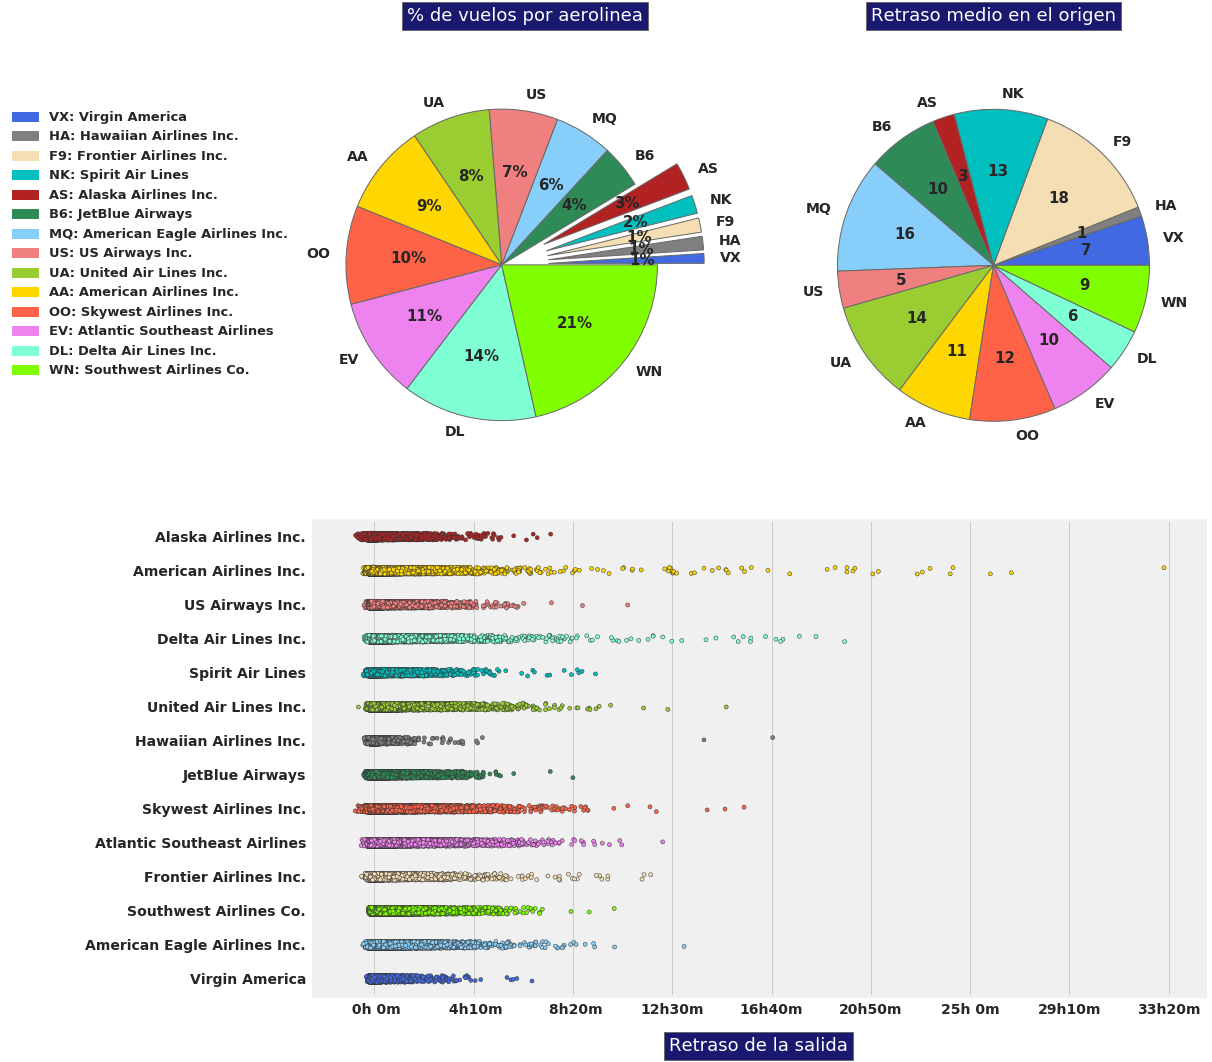

In [14]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% de vuelos por aerolinea', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Retraso medio en el origen', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Retraso de la salida', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

Teniendo en cuenta el primer gráfico circular que da el porcentaje de vuelos por aerolínea, vemos que hay cierta disparidad entre los operadores. Por ejemplo, Southwest Airlines representa ~20% de los vuelos, que es similar a la cantidad de vuelos operados por las 7 aerolíneas más pequeñas. Sin embargo, si damos un vistazo al segundo gráfico circular, vemos que por el contrario, las diferencias en los retrasos entre las aerolíneas son menos pronunciadas. Excluyendo Hawaian Airlines y Alaska Airlines que informan retrasos medios extremadamente bajos, obtenemos que el tiempo de retraso medio es ~11 ± 7 minutos. 

Siendo pragmáticos este valor es bastante bajo, lo que significa que el estándar para cada aerolínea es respetar el cronograma establecido
.
Finalmente, la figura en la parte inferior hace un censo de todas las demoras que se midieron en enero de 2015. Esta representación da una idea de la dispersión de datos y pone en perspectiva la relativa homogeneidad que apareció en el segundo gráfico circular. De hecho, vemos que si bien todas las demoras promedio son de alrededor de 10 minutos, este bajo valor es una consecuencia del hecho de que la mayoría de los vuelos despegan a tiempo. Sin embargo, vemos que ocasionalmente, podemos enfrentar retrasos realmente grandes que pueden alcanzar algunas decenas de horas.

La gran mayoría de los retrasos cortos es visible en la siguiente figura:

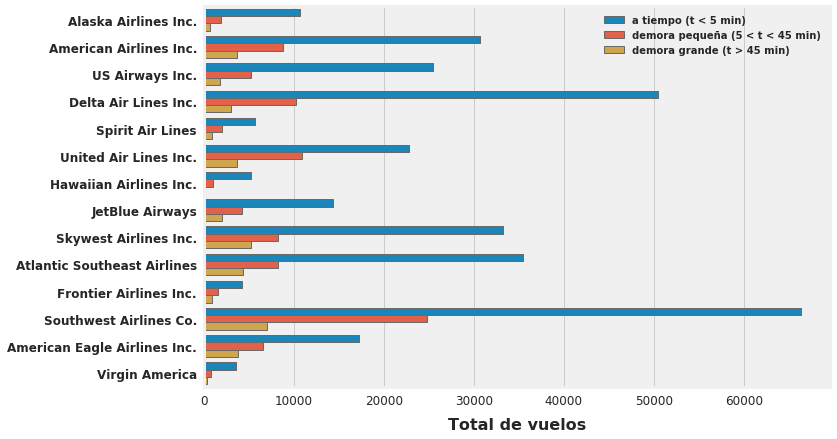

In [15]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Total de vuelos', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('a tiempo (t < 5 min)')
L.get_texts()[1].set_text('demora pequeña (5 < t < 45 min)')
L.get_texts()[2].set_text('demora grande (t > 45 min)')
plt.show()


Esta representa los retrasos de menos de 5 minutos, los que están en el rango de 5 < t < 45 min y, finalmente, los retrasos de más de 45 minutos. Por lo tanto, sabemos que, independientemente de la aerolínea, los retrasos superiores a 45 minutos solo representan unos pocos porcentajes. Sin embargo, la proporción de retrasos en estos tres grupos depende de la línea aérea: como un ejemplo, en el caso de *SkyWest Airlines*, los retrasos superiores a 45 minutos solo son inferiores $\sim$30% con respecto a retrasos en el rango de 5 < t < 45 min. Las cosas son mejores para *SoutWest Airlines* ya que las demoras superiores a 45 minutos son 4 veces menos frecuentes que las demoras en el rango de 5 < t < 45 min.




### 2.2 Distribución de los retrasos: estableciendo el ranking de las aerolíneas

Se mostró en la sección anterior que los retrasos medios se comportan de manera homogénea entre las aerolíneas (aparte de dos casos extremos) y es de alrededor de 11$\pm$7 minutos. Luego, vimos que este bajo valor es consecuencia de la gran proporción de vuelos que despegan a tiempo. Sin embargo, ocasionalmente, se pueden registrar grandes retrasos. En esta sección, examinamos más a fondo la distribución de retrasos para cada aerolínea.


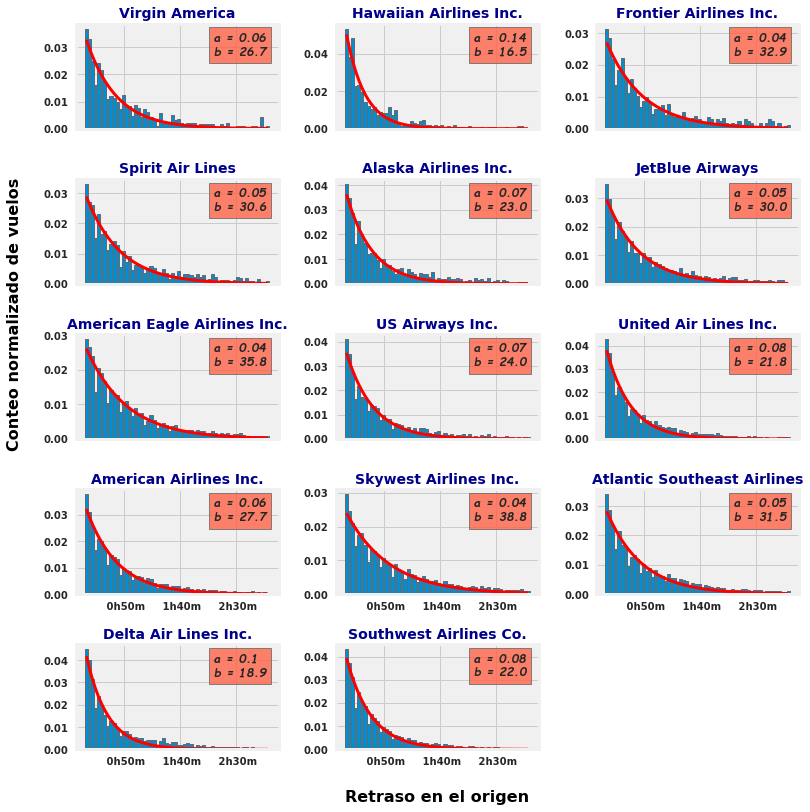

In [16]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Conteo normalizado de vuelos', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Retraso en el origen', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()


Esta figura muestra la distribución normalizada de retrasos que modelamos con una distribución exponencial $ f (x) = a \, 
\mathrm {exp} (-x / b) $. Los parámetros $a$ y $ $ obtenidos para describir cada aerolínea se muestran en la esquina superior derecha de cada panel.  Finalmente, de acuerdo con el valor de $a$ o $b$, es posible establecer una clasificación de las aerolíneas: los valores bajos de $a$ corresponderán a las aerolíneas con una gran proporción de retrasos importantes y, por el contrario , las aerolíneas que brillen por su puntualidad admitirán altos valores de $a$:

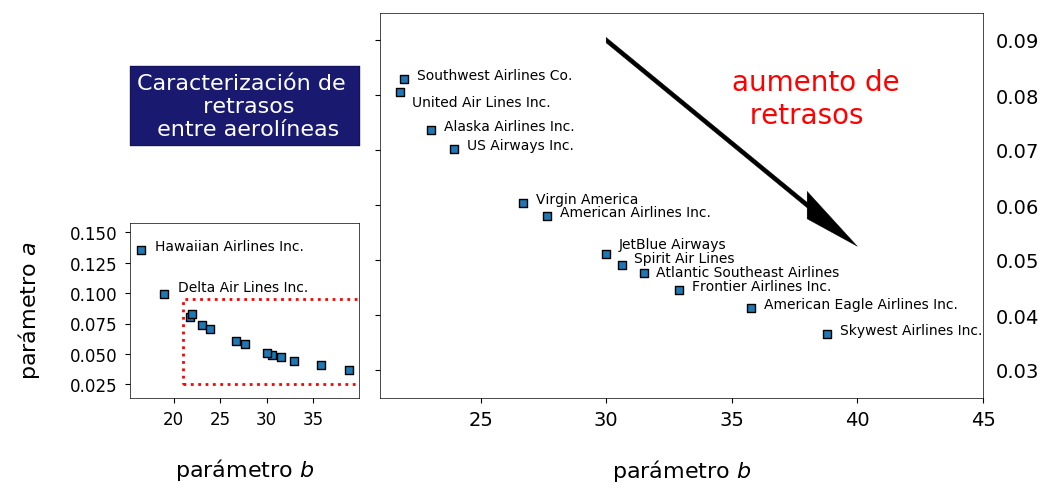

In [17]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("parámetro $b$", fontsize=16, labelpad=20)
plt.ylabel("parámetro $a$", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Caracterización de \n retrasos\n entre aerolíneas', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('aumento de \n  retrasos', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("parámetro $b$", fontsize=16, labelpad=20)
#--------------------------------
plt.show()


El panel izquierdo de esta figura ofrece una visión general de los coeficientes $a$ y $b$ de las 14 aerolínea,s mostrando que *Hawaiian Airlines* y *Delta Airlines* ocupan los dos primeros lugares. El panel derecho representa a otras 12 aerolíneas. Podemos ver que SouthWest Airlines, que representa $\sim$20% del número total de vuelos, está bien clasificada y ocupa la tercera posición. De acuerdo con este ranking, SkyWest Airlines es la peor aerolínea.


### 3. Retrasos: en el despegue o en el aterrizaje ?

En la sección anterior, toda la discusión se realizó sobre retrasos en la salida. Sin embargo, estos retrasos difieren un poco de los retrasos registrados en el aterrizaje:

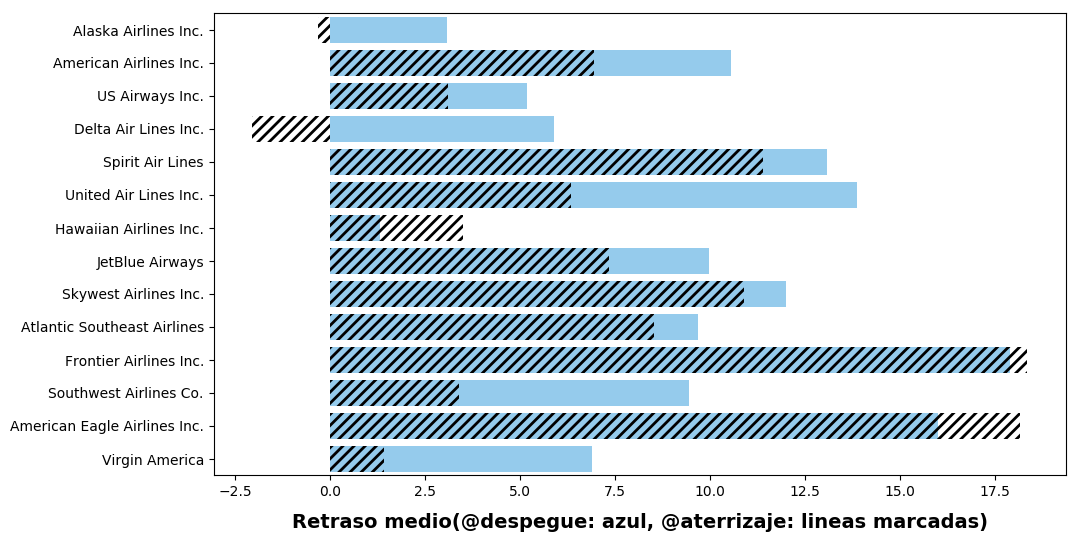

In [18]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Retraso medio(@despegue: azul, @aterrizaje: lineas marcadas)',
           fontsize=14, weight = 'bold', labelpad=10);

En esta figura, podemos ver que los retrasos en la llegada son generalmente más bajos que en el momento de la partida. Esto indica que las aerolíneas ajustan su velocidad de vuelo para reducir los retrasos a la llegada. 

Desde este momento estaremos usando únicamente los datos de retrasos en la salida, por ser los de mayor percepción para los pasajeros.


## 4. Relación entre el aeropuerto de origen y los retrasos

Ahora intentaremos definir si existe una correlación entre los retrasos registrados y el aeropuerto de origen. Recuerdemos que en el conjunto de datos, el número de aeropuertos considerados es 312:

In [19]:
print("No de aeropuertos: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

No de aeropuertos: 312



### 4.1 Área geográfica cubierta por las aerolíneas 

Hagamos una rápida mirada al número de aeropuertos que cubre una aerolínea: 

In [20]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

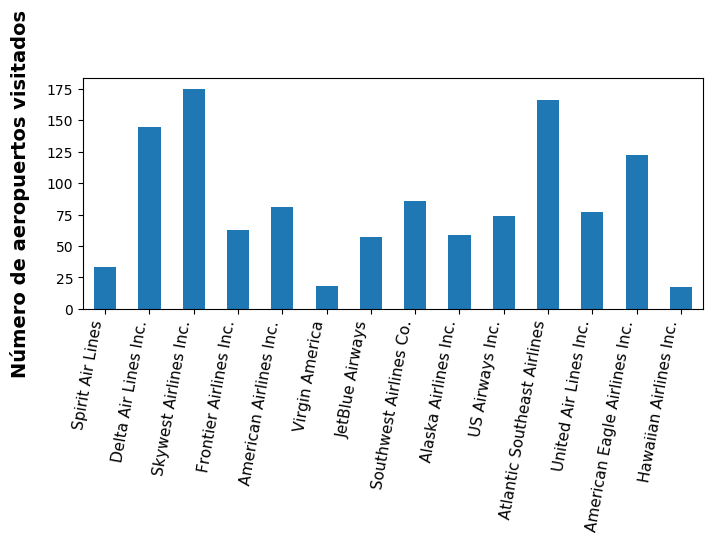

In [21]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Número de aeropuertos visitados', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [22]:
temp = pd.read_csv('airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

___
### 4.2 Cómo el aeropuerto de origen impacta los retrasos

En esta sección, veremos  las variaciones de los retrasos con respecto al aeropuerto de origen y para cada aerolínea. El primer paso consiste en determinar los retrasos medios por aeropuerto:

In [23]:
temp = pd.read_csv('airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 



Dado que el número de aeropuertos es bastante grande, un gráfico que muestre toda la información a la vez sería un poco desordenado, ya que representaría alrededor de 4400 valores (es decir, 312 aeropuertos $\times$ 14 aerolíneas). Por lo tanto, solo representaremos un subconjunto de los datos:

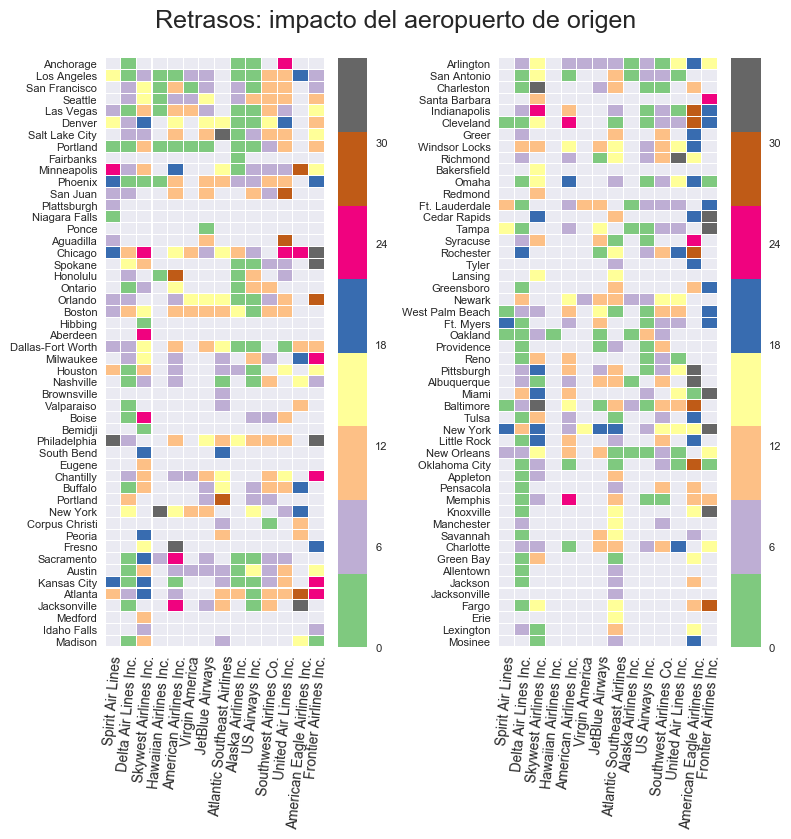

In [24]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Retrasos: impacto del aeropuerto de origen", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()



Esta figura permite sacar algunas conclusiones. En primer lugar, al observar los datos asociados con las diferentes aerolíneas, encontramos el comportamiento que observamos anteriormente: por ejemplo, si consideramos el panel derecho, se verá que la columna asociada con *American Eagle Airlines* reporta principalmente grandes retrasos, mientras que la columna asociada con *Delta Airlines* se asocia principalmente con retrasos de menos de 5 minutos. Si ahora miramos los aeropuertos de origen, veremos que algunos aeropuertos favorecen las salidas tardías: ver por ejemplo Denver, Chicago o Nueva York. Por el contrario, otros aeropuertos tienen principalmente salidas a tiempo como Portland o Oakland.

Finalmente, podemos deducir de estas observaciones que existe una alta variabilidad en las demoras promedio, tanto entre los diferentes aeropuertos como entre las diferentes aerolíneas. Esto es importante porque implica que para modelar con precisión las demoras, será necesario adoptar un modelo **específico para la aerolínea y el aeropuerto local**.



___
### 4.3 Vuelos con retrasos habituales?

En la sección anterior, se ha visto que hay una variabilidad en los retrasos cuando se consideran las diferentes aerolíneas y los diferentes aeropuertos de origen. Ahora vamos a agregar un nivel de granularidad al enfocar no solo en los aeropuertos de origen, sino también en los vuelos: origen $\to$ destino. El objetivo aquí es ver si algunos vuelos se retrasan sistemáticamente o si, por el contrario, hay vuelos que siempre llegan a tiempo.

En lo que sigue, consideramos el caso de una sola aerolínea. Enumero todos los vuelos A $\to$ B llevados a cabo por esta aerolínea y para cada uno de ellos, creamos la lista de retrasos que se han registrado:

In [31]:
#_________________________________________________________________
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()



Luego calculamos el retraso promedio en las diversas rutas A $\to$ B, así como la desviación estándar y una vez hecho, creamos una representación gráfica (para una muestra de los vuelos):


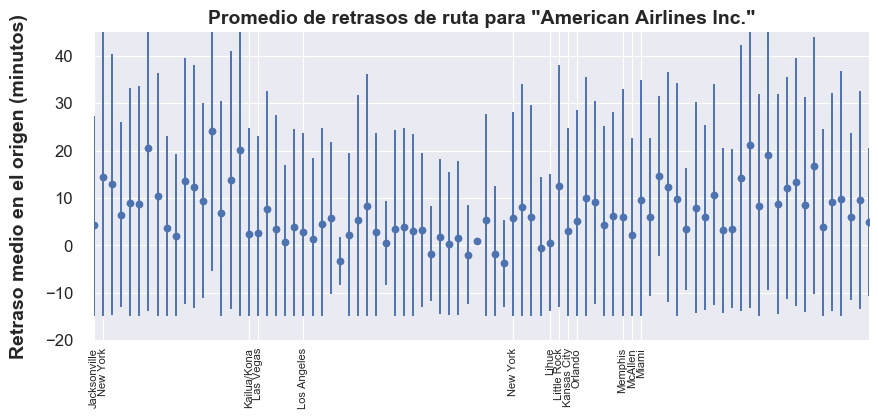

In [32]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Promedio de retrasos de ruta para "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Retraso medio en el origen (minutos)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()



Esta cifra proporciona los retrasos promedio para American Airlines, de acuerdo con la ciudad de origen y el destino (tenga en cuenta que en el eje X, solo se indica el origen en aras de la claridad).  En este ejemplo, se puede observar que para un aeropuerto de origen dado, las demoras fluctuarán dependiendo del destino. Vemos, por ejemplo, que aquí las mayores variaciones se obtienen para Nueva York o Miami, donde las demoras promedio iniciales varían entre 0 y $\sim$20 minutos.



___
### 4.4 Variabilidad temporal de las demoras

En esta sección, miro la forma en que los retrasos varían con el tiempo. Teniendo en cuenta el caso de una aerolínea y un aeropuerto específicos, las demoras se pueden representar fácilmente por día y hora (nota: antes de hacer esto, defino una clase que usaremos ampliamente en lo que sigue para producir gráficos):

In [33]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])           

Para la aerolinea Southwest Airlines:

In [34]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)

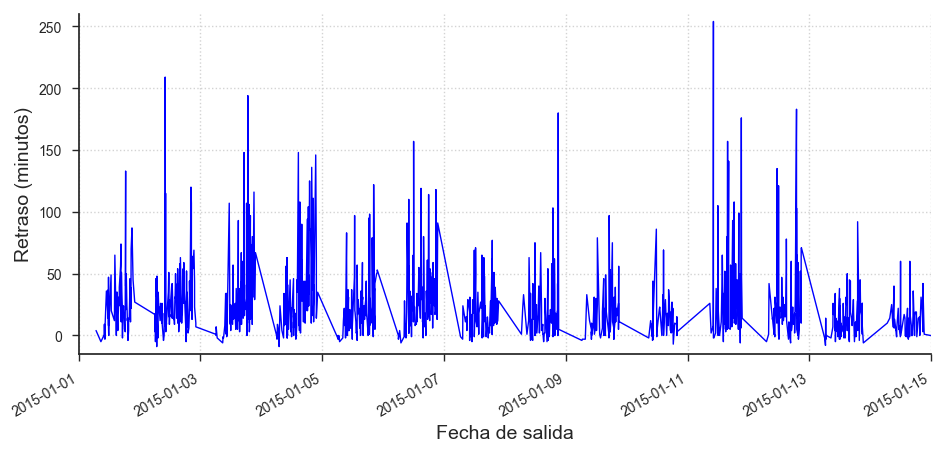

In [35]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Retraso (minutos)', fontsize = 14)
fig1.set_xlabel('Fecha de salida', fontsize = 14)
date_1 = datetime.datetime(2015,1,1)
date_2 = datetime.datetime(2015,1,15)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)


Esta figura muestra la existencia de ciclos, tanto en la frecuencia de los retrasos como en su magnitud. De hecho, intuitivamente, parece bastante lógico observar tales ciclos, ya que serán consecuencia de la alternancia diurna y nocturna y del hecho de que la actividad aeroportuaria se ve muy reducida (si no inexistente) durante la noche. Esto sugiere que una **variable importante** en el modelado de retrasos será **la hora de despegue**. Para verificar esta hipótesis, observamos el comportamiento de la demora media en función de la hora de salida, agregando los datos del mes actual:

In [36]:
#_______________________________
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
#_______________________________
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
fct = lambda x:x.hour*3600+x.minute*60+x.second
x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['mean']
popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

lo que visualmente resulta en:

In [ ]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot_date(df2['heure_depart'], df2['DEPARTURE_DELAY'],
                    markeredge=False, label='datos iniciales')
fig1.cust_plot(test2.index, test2['mean'], linestyle='--', linewidth=2, label='promedio')
fig1.cust_plot(test2.index, test2['fit'], color='r', linestyle='-', linewidth=3, label='fit')
fig1.style() ; fig1.draw_legend('upper left')
fig1.set_ylabel('Retraso (minutos)', fontsize = 14)
fig1.set_xlabel('Hora de salida', fontsize = 14)
fig1.set_ylim(-15, 210)



Aquí podemos ver que la demora promedio tiende a aumentar con la hora de salida a medida que transcurre el día: los vuelos salen generalmente a tiempo por la mañana y la demora crece de forma casi monótona hasta 30 minutos al final del día. De hecho, este comportamiento es bastante general y si miramos otros aeropuertos o compañías, encontraríamos tendencias similares.



__
## 5. Predicción de retrasos de vuelo 


Las secciones previas trataban sobre exploración del conjunto de datos. Ahora iniciariemos con la creación de un modelo de retrasos en los vuelos. En esta sección, el objetivo es crear un modelo que use una ventana de 3 semanas para predecir los retrasos de la semana siguiente. Por lo tanto, decidemos trabajar en los datos de enero con el objetivo de predecir los retrasos de la época del $23^{th}-31^{th}$ de Enero

In [ ]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train


Consideremos los vuelos de * American Airlines * y hagamos un censo de la cantidad de vuelos que salieron de cada aeropuerto.  Solo se deben crear modelos cuando el numero de mediciones es significativ. Fijarse por ejemplo que el aeropuerto MTJ solo tiene 3 registros, estadísticamente muy poco para crear un modelo.

In [ ]:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]



Al mirar esta lista, podemos ver que los aeropuertos menos visitados solo tienen algunos vuelos en un mes. Por lo tanto, en el caso menos favorable, es imposible realizar una regresión para esos datos.


Otra dificultad que debe evitarse es la de los retrasos "accidentales": se debe prestar especial atención a los retrasos extremos. De hecho, durante la exploración, se observó que ocasionalmente, se podían registrar retrasos de varias horas (incluso decenas de horas). Este tipo de retraso es, sin embargo, marginal (un pequeño %) y la causa de estos retrasos probablemente esté vinculada a eventos impredecibles (clima, avería, accidente, ...). Por otro lado, teniendo en cuenta un retraso de este tipo, es probable que introduzca un sesgo en el análisis. Además, el peso tomado por valores grandes será significativo si tenemos una estadística pequeña.
Para ilustrar esto, primero defino una función que calcula el retraso medio de los vuelos por aerolínea y por aeropuerto:

In [ ]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

___
### 5.1 Creación de un modelo polinomial : Dividir el conjunto de datos


En la práctica, en lugar de realizar una regresión lineal simple para el modelo, podemos crear un modelo polineal de orden $N$. Al hacerlo, es necesario definir el grado $N$ que es óptimo para representar los datos. Al aumentar el orden del polinomio, es importante ** evitar el ajuste excesivo u over-fitting ** y lo hacemos dividiendo el conjunto de datos en **conjuntos de prueba y entrenamiento(train and test)**. Un problema que puede surgir con este procedimiento es que el modelo termina *indirectamente* aprendiendo el contenido del conjunto de prueba y, por lo tanto, es sesgado (biased). Para evitar esto, los datos se pueden volver a separar en 3 conjuntos: *train*, *test* y *validation*. Una alternativa a esta técnica, que a menudo es más robusta, es el llamado método de validación cruzada o cross validation. Este método consiste en realizar una primera separación de los datos en los conjuntos *train* y *test*. Como siempre, el aprendizaje se realiza en el conjunto de datos de training, pero para evitar el exceso de aprendizaje, se divide en varias piezas que se utilizan alternativamente para el entrenamiento y pruebas.




Tenga en cuenta que si el conjunto de datos es pequeño, la separación en los conjuntos de prueba y entrenamiento puede introducir un sesgo en la estimación de los parámetros. En la práctica, el método *cross-validation evita dicho sesgo. De hecho, en el modelo actual, encontraremos este tipo de escenario. Por ejemplo, podemos considerar un caso extremo en el que, después de la separación de los datos, el conjunto de entrenamiento contendría solo retrasos de tiempo $ <$ 20h y el conjunto de prueba tendría retrasos de tiempo de $>$ 20h. El modelo entonces no podría reproducir precisamente estos datos, de los cuales no se habría visto equivalente durante el entrenamiento. El método de validación cruzada o cross validation evita este sesgo ya que todos los datos se usan sucesivamente para crear el modelo.

** a) Sesgo introducido por la separación del conjunto de datos **

Para probar el impacto de la separación de datos en la determinación del modelo, primero definimos la clase * fit_polynome *

In [ ]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)


La clase * fit_polynome * permite realizar todas las operaciones relacionadas con un FIT y guardar los resultados. Al llamar al método ** split () **, la variable '* method *' define cómo se separan los datos iniciales:
- * method = 'all' *: todos los datos de entrada se usan para entrenar y luego probar el modelo
- * method = 'split' *: utilizamos el método * train_test_split () * de sklearn para definir conjuntos de prueba y entrenamiento
 
Los otros métodos de la clase tienen las siguientes funciones:
- ** train (n) **: lleva los datos al conjunto de entrenamiento y crea un polinomio de orden n
- ** predicción (X) **: calcula los puntos Y asociados con la entrada X y para el modelo accionado previamente
- ** calc_score () **: calcula el puntaje del modelo en relación con los datos del conjunto de prueba

Para ilustrar el sesgo introducido por la selección del conjunto de pruebas, procedo de la siguiente manera: realizo varias separaciones de "Entrenamiento / prueba" de un conjunto de datos y para cada caso, ajustamos polinomios de órdenes ** n = 1, 2 y 3 **, calculando sus puntajes respectivos. Luego, muestramos que de acuerdo con la elección de la separación, la mejor puntuación se puede obtener con cualquiera de los valores de ** n **. En la práctica, es suficiente llevar a cabo una docena de modelos para obtener este resultado. Además, este sesgo se introduce mediante la elección de la separación "Entrenamiento / prueba" y los resultados del pequeño tamaño del conjunto de datos que se modelará. De hecho, a continuación, tomamos como ejemplo el caso de la aerolínea * American Airlines * (la segunda aerolínea más grande) y el aeropuerto de id 1129804, que es el aeropuerto con más vuelos registrados para esa compañía. Este es uno de los escenarios menos favorables para la aparición de este tipo de sesgo, que, sin embargo, está presente:

In [ ]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("Modelo nº{:<2}, min. pour n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "orden polinomial:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break


En esta figura, los paneles de izquierda a derecha corresponden a 3 separaciones de los datos en conjunto de datos de entrenamiento y conjuntos de datos de prueba, para lo cual se obtienen los mejores modelos respectivamente con polinomios de orden 1, 2 y 3. En cada uno de estos paneles, los 3 polinomios han sido representados y el mejor modelo corresponde a la curva gruesa.

** b) Selección por validación cruzada**
Una de las ventajas del método de validación cruzada es que evita el sesgo que se acaba de presentar al elegir el grado polinómico. Para usar este método, definimos una nueva clase que usaremos más adelante para realizar los ajustes:

In [ ]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'mean_squared_error'))


Esta clase tiene dos métodos:
- ** train (n, nb_folds) **: conjuntos de entrenamiento 'nb_folds' definidos a partir del conjunto de datos inicial e impulsa un polinomio de orden 'n' en cada uno de estos conjuntos. Este método devuelve como resultado las predicciones Y obtenidas para los diferentes conjuntos de prueba.
- ** calc_score (n, nb_folds) **: realiza el mismo procedimiento que un método ** train **, excepto que este método calcula el puntaje de ajuste y no los valores predecidos en los diferentes datos de prueba.

Por defecto, los métodos sklearn *cross_val_predict ()* y *cross_val_score ()* utilizan el método 'K-fold'. Estos métodos son deterministas en la elección de los pliegues K, lo que implica que para un valor K fijo, los resultados obtenidos usando estos métodos siempre serán idénticos. Como se vio en el ejemplo anterior, este no fue el caso cuando se usaba el método train_test_split (). Por lo tanto, si tomamos el mismo conjunto de datos que en el ejemplo anterior, el método de validación cruzada permite elegir el mejor grado polinomial:


In [ ]:
#id_airport = 1129804 
nb_folds = 10
print('Máximo número posible de folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))



Podemos ver que el uso de este método nos da que el mejor modelo (es decir, el mejor modelo generalizado) se obtiene con un polinomio de orden 1. En esta etapa del proceso la elección del orden del polinomio ha sido validada y ahora podemos usa todos los datos para realizar el ajuste:

In [ ]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 1)
fit.predict(fit.X)


Por lo tanto, en la siguiente figura, la yuxtaposición de los ajustes polinómicos K = 50 correspondientes al cálculo de validación cruzada conduce a la curva roja. El ajuste polinómico correspondiente al modelo final corresponde a la curva azul.

In [ ]:
fit2.train(pol_order = 1, nb_folds = nb_folds)

In [ ]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'Puntos iniciales de datos')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='Salida del Cross Validation')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='Salida final')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Retraso (minutos)') ; fig1.set_xlabel('Hora de despegue')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

In [ ]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

___
### 5.2 Pruebas del modelo: Prediccion de retrasos de la última semana de Enero



En esta etapa, el modelo es probado en el conjunto de entrenamiento que incluye los datos de las primeras 3 semanas de enero. Ahora vemos la comparación de predicciones y observaciones para la cuarta semana de enero:

In [ ]:
test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

El puntaje MSE del modelo es:

In [ ]:
score = metrics.mean_squared_error(fit.result, Y_test)
score

Para darse una idea del siginificado de ese valor, asumimos un error constante en cada punto del conjunto de datos.  En este caso, en cada punto $ i $ tenemos:

\begin{eqnarray}
y_i - f(x_i) = cste = \sqrt{MSE}
\end{eqnarray}




dando así la diferencia en minutos entre la demora prevista y la demora real. En este caso, la diferencia entre el modelo y las observaciones es típicamente:

In [3]:
'desviacion = {:.2f} min'.format(np.sqrt(score))

NameError: name 'score' is not defined

** Cualquier mejora o error presente por favor informarme** <br>
** msanchez@microsoft.com**